In [2]:
from plotly.subplots import make_subplots
from analysing_functions import *
from IIRfilter import *
# IF you are using Pycharm
import plotly.io as pio
from scipy import fftpack, signal, stats

target = 4
env = "W"
block = 2
subject = 303
## Bring the result into pandas dataframe
holo, imu, eye = bring_data(target, env, block, subject)
## Get the delayed time between hololens - laptop
shift, corr, shift_time = synchronise_timestamp(imu, holo, show_plot=False)

## filter out the low-confidene eye data
# eye = eye[eye.confidence > 0.8]

## match the delayed timestamp into hololens' timestamp
eye.timestamp = eye.timestamp - shift_time
# eye.norm_y = eye.norm_y - eye.norm_y.mean()
## For easy manipulation/check, make all dataframes into 120Hz, and make same timestamp by interpolation (1-dimensional)
new_holo, new_imu, new_eye = interpolated_dataframes(holo, imu, eye)

In [11]:
def asSpherical(xyz: list):
    # takes list xyz (single coord)
    x = xyz[0]
    y = xyz[1]
    z = xyz[2]
    r = math.sqrt(x * x + y * y + z * z)
    theta = math.acos(z / r) * 180 / math.pi  # to degrees
    phi = math.atan2(y, x) * 180 / math.pi
    return [r, theta, phi]

def calculate_max_angle(fromX,fromY,fromZ,toX,toY,toZ,r):
    length = np.sqrt((toX-fromX)**2 + (toY-fromY)**2 + (toZ-fromZ)**2)
    angle_in_rad=np.arcsin(r/length)

    return np.rad2deg(angle_in_rad)

def calculate_current_angle(headX,headY,headZ,fromX,fromY,fromZ,toX,toY,toZ):
    import vg
    vector1 = np.array([headX,headY,headZ])
    vector2 = np.array([toX-fromX,toY-fromY,toZ-fromZ])
    return vg.angle(vector1,vector2)

def add_columns(holo):
    rs = []
    thetas = []
    phis = []
    for index, row in holo.iterrows():
        x = row['target_position_x'] - row['head_position_x']
        y = row['target_position_y'] - row['head_position_y']
        z = row['target_position_z'] - row['head_position_z']
        [r, theta, phi] = asSpherical([x, z, y])
        rs.append(r)
        thetas.append(90 - theta)
        phis.append(90 - phi)

    holo['R'] = rs
    holo['Theta'] = thetas
    holo['Phi'] = phis
    holo['TargetVertical'] = holo.head_rotation_x + holo.Theta
    holo['TargetHorizontal'] = holo.head_rotation_y - holo.Phi
    for col in ['head_forward_x', 'head_forward_y', 'head_forward_z']:
        holo[str(col) + '_next'] = holo[col].shift(1)
    holo['time_interval'] = holo.timestamp.diff()
    holo['angle_speed'] = holo.apply(lambda x: angle_velocity(x.head_forward_x, x.head_forward_y, x.head_forward_z,
                                                                        x.head_forward_x_next, x.head_forward_y_next,
                                                                        x.head_forward_z_next,
                                                                        x.time_interval), axis=1)
    return holo

def angle_velocity(x1, y1, z1, x2, y2, z2, _time):
    import vg
    # if type(_head_forward2) is not dict: return None
    vector1 = np.array([x1, y1, z1])
    vector2 = np.array([x2, y2, z2])
    return vg.angle(vector1, vector2) / _time

# subjects = subjects = range(301, 317)
# poss = ['W']
# envs = ['U','W']
# targets=range(8)
# # blocks=range(5)
# blocks = [1,2,3,4]
# output=pd.DataFrame()
# for subject in subjects:
#     for target, env, pos, block in itertools.product(targets, envs, poss, blocks):
#         holo, imu, eye = bring_data(target, env, block, subject)
#         current_info = [target, env, pos, block]
#         print(subject,current_info)
#         ## Get the delayed time between hololens - laptop
#         shift, corr, shift_time = synchronise_timestamp(imu, holo, show_plot=False)
#
#         holo.timestamp = holo.timestamp - holo.timestamp[0]
#         holo = add_columns(holo)
#         if holo[holo.target_entered ==True].shape[0]<1:
#             print('no target-in');continue
#
#         start_index= holo[ holo.target_entered==True].index[0]
#         holo_after_target_on= holo[holo.index>start_index]
#         accuracy_vertical = -holo_after_target_on.Theta.mean()-holo_after_target_on.head_rotation_x.mean()
#         accuracy_horizontal=holo_after_target_on.Phi.mean()-holo_after_target_on.head_rotation_y.mean()
#         precision_vertical=(holo_after_target_on.TargetVertical).std()
#         precision_horizontal=(holo_after_target_on.TargetHorizontal).std()
#         result =dict(
#             subject=subject,target=target,env=env,block=block,
#             accuracy_vertical=accuracy_vertical,accuracy_horizontal=accuracy_horizontal,
#             precision_vertical=precision_vertical,precision_horizontal=precision_horizontal
#         )
#         output=output.append(result,ignore_index=True)
#

301 [0, 'U', 'W', 1]
301 [0, 'U', 'W', 2]
301 [0, 'U', 'W', 3]
301 [0, 'U', 'W', 4]
301 [0, 'W', 'W', 1]
301 [0, 'W', 'W', 2]
301 [0, 'W', 'W', 3]
301 [0, 'W', 'W', 4]
301 [1, 'U', 'W', 1]
301 [1, 'U', 'W', 2]
301 [1, 'U', 'W', 3]
301 [1, 'U', 'W', 4]
301 [1, 'W', 'W', 1]
301 [1, 'W', 'W', 2]
301 [1, 'W', 'W', 3]
301 [1, 'W', 'W', 4]
301 [2, 'U', 'W', 1]
301 [2, 'U', 'W', 2]
301 [2, 'U', 'W', 3]
301 [2, 'U', 'W', 4]
301 [2, 'W', 'W', 1]
301 [2, 'W', 'W', 2]
301 [2, 'W', 'W', 3]
301 [2, 'W', 'W', 4]
301 [3, 'U', 'W', 1]
301 [3, 'U', 'W', 2]
301 [3, 'U', 'W', 3]
301 [3, 'U', 'W', 4]
301 [3, 'W', 'W', 1]
301 [3, 'W', 'W', 2]
301 [3, 'W', 'W', 3]
301 [3, 'W', 'W', 4]
301 [4, 'U', 'W', 1]
301 [4, 'U', 'W', 2]
301 [4, 'U', 'W', 3]
301 [4, 'U', 'W', 4]
301 [4, 'W', 'W', 1]
301 [4, 'W', 'W', 2]
301 [4, 'W', 'W', 3]
301 [4, 'W', 'W', 4]
301 [5, 'U', 'W', 1]
301 [5, 'U', 'W', 2]
301 [5, 'U', 'W', 3]
301 [5, 'U', 'W', 4]
301 [5, 'W', 'W', 1]
301 [5, 'W', 'W', 2]
301 [5, 'W', 'W', 3]
301 [5, 'W', 

In [13]:
# UI_accuracy_H = output[output.env=='U'].accuracy_horizontal.mean()
# UI_accuracy_V = output[output.env=='U'].accuracy_vertical.mean()
# World_accuracy_H =output[output.env=='W'].accuracy_horizontal.mean()
# World_accuracy_V =output[output.env=='W'].accuracy_vertical.mean()
#
# UI_precision_H = output[output.env=='U'].precision_horizontal.mean()
# UI_precision_V = output[output.env=='U'].precision_vertical.mean()
# World_precision_H =output[output.env=='W'].precision_horizontal.mean()
# World_precision_V =output[output.env=='W'].precision_vertical.mean()
#
# print('accuracy',UI_accuracy_H,UI_accuracy_V,World_accuracy_H,World_accuracy_V)
# print('precision',UI_precision_H,UI_precision_V,World_precision_H,World_precision_V)
#
#

accuracy -0.005932535678883327 0.07748426154913907 -0.030753247800596444 0.10274957305906984
precision 0.9941056776623312 1.0535070841226597 0.9971665582937062 1.0838673847425893


In [14]:
# # subjects = subjects = range(301, 317)
# # poss = ['W']
# # envs = ['U','W']
# # targets=range(8)
# # blocks = [1,2,3,4]
# subjects=[301]
# poss=['W']
# envs=['U']
# targets=[1]
# blocks=[1]
# output=pd.DataFrame()
# for subject in subjects:
#     for target, env, pos, block in itertools.product(targets, envs, poss, blocks):
#         holo, imu, eye = bring_data(target, env, block, subject)
#         current_info = [target, env, pos, block]
#         print(subject,current_info)
#         ## Get the delayed time between hololens - laptop
#         shift, corr, shift_time = synchronise_timestamp(imu, holo, show_plot=False)
#
#         holo.timestamp = holo.timestamp - holo.timestamp[0]
#         holo = add_columns(holo)
#         eye.timestamp = eye.timestamp - shift_time
#
#         ## For easy manipulation/check, make all dataframes into 120Hz, and make same timestamp by interpolation (1-dimensional)
#         new_holo, new_imu, new_eye = interpolated_dataframes(holo, imu, eye)
#         # for i in range(new_holo.shape[0]):
#

301 [1, 'U', 'W', 1]


In [17]:
# print(new_holo.timestamp[2:10])
# """
#  1. filter eye-data with filtfilt
#  2. set window size
#  3. calculate mean difference and scale for windowed-range
#  4. apply shift/scale to new eye-data arrives
#  5. compare accuracy/precision with raw head movement
# """

2    0.016667
3    0.025000
4    0.033333
5    0.041667
6    0.050000
7    0.058333
8    0.066667
9    0.075000
Name: timestamp, dtype: float64


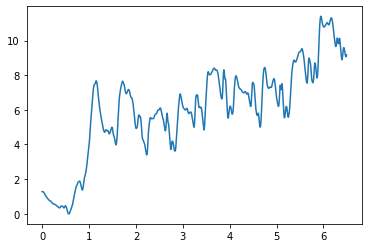

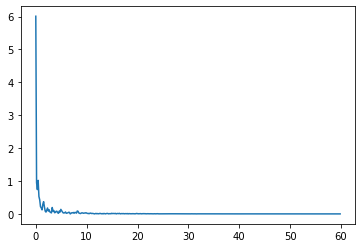

outer count: 59
freq= 0.0 coec= 6.010056922490525  coes -0.0
freq= 0.46153846153846156 coec= -0.0892065519096395  coes -1.019610158094105
freq= 0.15384615384615385 coec= -0.2068470181821295  coes -0.927271247740391
freq= 0.3076923076923077 coec= -0.19005460202323368  coes -0.718932881605526
freq= 0.6153846153846154 coec= 0.06920954857210701  coes -0.5298438388534509
freq= 0.7692307692307693 coec= 0.07630524010991713  coes -0.42635445973690006
freq= 1.5384615384615385 coec= -0.17107049985698933  coes -0.3355055456538954
freq= 1.3846153846153846 coec= -0.2516292510155881  coes -0.1608808630623447
freq= 0.9230769230769231 coec= 0.023520950539536237  coes -0.22433490569497433
freq= 1.6923076923076925 coec= 0.16783361587431883  coes 0.14521783867607344
freq= 3.230769230769231 coec= -0.1747231621503424  coes -0.09688924627315439
freq= 1.076923076923077 coec= 0.11109371761509904  coes -0.1506274409686255
freq= 2.307692307692308 coec= -0.03342457383170014  coes -0.18105346749769002
freq= 4.923

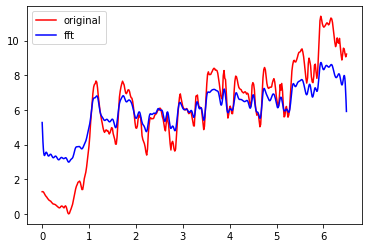

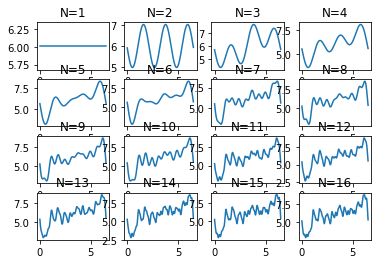

In [39]:
target = 4
env = "W"
block = 2
subject = 303
## Bring the result into pandas dataframe
holo, imu, eye = bring_data(target, env, block, subject)
## Get the delayed time between hololens - laptop
shift, corr, shift_time = synchronise_timestamp(imu, holo, show_plot=False)

## filter out the low-confidene eye data
# eye = eye[eye.confidence > 0.8]

## match the delayed timestamp into hololens' timestamp
eye.timestamp = eye.timestamp - shift_time


x = holo.head_rotation_x

from scipy.interpolate import splrep,splev
spl = splrep(holo.timestamp,holo.head_rotation_x)
fs = 60*2
dt=1/fs
spl=splrep(holo.timestamp,holo.head_rotation_x)
newt=np.arange(0,holo.timestamp.values[-1],dt)
newx=splev(newt,spl)

plt.plot(newt,newx)
plt.show()

nfft = len(newt)
df = fs/nfft
k=np.arange(nfft)
f=k*df

nfft_half=math.trunc(nfft/2)
f0=f[range(nfft_half)]
y=np.fft.fft(newx)/nfft
y0=y[range(nfft_half)]
amp=abs(y0)

plt.plot(f0,amp)
plt.show()

ampsort = np.sort(amp)
q1,q3 = np.percentile(ampsort,[25,75])
iqr=q3-q1
upper_bound = q3+1.5*iqr
outer=ampsort[ampsort>upper_bound]
topn=len(outer)
print('outer count:' ,len(outer))

idxy=np.argsort(-amp)
# for i in range(topn):
#     print()
newy=np.zeros((nfft,))
arfreq=[]
arcoec=[]
arcoes=[]
for i in range(topn):
    freq=f0[idxy[i]]
    yx=y[idxy[i]]
    coec=yx.real
    coes=yx.imag*-1
    newy += coec * np.cos(2 * np.pi * freq * newt) + coes * np.sin(2 * np.pi * freq * newt)
    arfreq.append(freq)
    arcoec.append(coec)
    arcoes.append(coes)
plt.plot(holo.timestamp,holo.head_rotation_x,c='r',label='original')
plt.plot(newt,newy,c='b',label='fft')
plt.legend()
plt.show()

plti=0
ncnt=15

newy = np.zeros((nfft,))
for i in range(ncnt+1):
    freq = f0[idxy[i]]
    yx = y[idxy[i]]
    coec = yx.real
    coes = yx.imag * -1
    print('freq=', freq, 'coec=', coec, ' coes', coes)
    newy += coec * np.cos(2 * np.pi * freq * newt) + coes * np.sin(2 * np.pi * freq * newt)
    plti+=1
    plt.subplot(4,4, plti)
    plt.title("N={}".format(i+1))
    plt.plot(newt, newy)
    # plt.savefig('fft02_5.jpg')
plt.show()


# x =eye.norm_y - eye.norm_y.mean()
# fmax = 120
# dt = 1/fmax
# N = x.size
# t = np.arange(0,N)*dt
# plt.subplot(2,1,1)
# plt.plot(t,x,label='head')
# plt.legend()
# plt.xlabel('time');plt.ylabel('x(t)');plt.grid()
#
# df = fmax/N
# f = np.arange(0,N)*df
#
# xf = np.fft.fft(x)*dt
# plt.subplot(2,1,2)
# plt.plot(f[0:int(N/2+1)],np.abs(xf[0:int(N/2+1)]))
# plt.xlabel('frequency(Hz)');plt.ylabel('abs(xf)');plt.grid()
# plt.tight_layout()
#
# plt.show()
#
# sp=np.fft.fft(x)
# freq=np.fft.fftfreq(t.shape[-1])
# plt.plot(freq,sp)
# plt.show()
#
# csp = np.copy(sp)
# csp[3:-3]=0
# iffted_x = np.fft.ifft(csp)
# plt.plot(x)
# plt.plot(iffted_x)
# plt.show()